In [1]:
from pathlib import Path
from datetime import datetime
from dateutil import tz

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy
from metpy.plots import USCOUNTIES
import numpy as np
import xarray as xr
from siphon.catalog import TDSCatalog

In [2]:
# Choices are 'Mesoscale-1', 'Mesoscale-2', 'CONUS', or 'FullDisk'
SECTOR = 'CONUS'

In [3]:
def get_satellite(sector ,channel: str):
    satcat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/'
                        f'{SECTOR}/Channel{channel}/current/catalog.xml')
    dataset = satcat.datasets[0]
    dataset = dataset.remote_access(use_xarray=True)
    return dataset

In [4]:
vis_channels = []

for channel in ['01', '02', '03']:
    if SECTOR == 'CONUS' and channel == '02':
        ds = get_satellite(SECTOR, channel)
        ds = ds[{'x': slice(None, None, 2), 'y': slice(None, None, 2)}]
        vis_channels.append(ds)
    else:
        ds = get_satellite(SECTOR, channel)
        vis_channels.append(ds)

In [5]:
# Channel 1 is 'Blue', Channel 2 is 'Red', Channel 3 is 'Green'
R = vis_channels[1].metpy.parse_cf('Sectorized_CMI').values
G = vis_channels[2].metpy.parse_cf('Sectorized_CMI').values
B = vis_channels[0].metpy.parse_cf('Sectorized_CMI').values

In [6]:
# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)

In [7]:
# Apply a gamma correction to the image to correct ABI detector brightness
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)

In [8]:
# Calculate the "True" Green
G_true = 0.45 * R + 0.1 * G + 0.45 * B
G_true = np.clip(G_true, 0, 1)  # apply limits again, just in case.

In [9]:
# The RGB array with the raw veggie band
RGB_veggie = np.dstack([R, G, B])

# The RGB array for the true color image
RGB = np.dstack([R, G_true, B])

In [10]:
data = vis_channels[0].metpy.parse_cf('Sectorized_CMI')
proj = data.metpy.cartopy_crs
x = data['x']
y = data['y']

def convert_datetime(mrms_time):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New York')
    utc_time = datetime.strptime(mrms_time, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

VALID_TIME = convert_datetime(str(data['time'].values).split('.')[0])

In [11]:
def contrast_correction(color, contrast):
    """Modify the contrast of an RGB.
    See:
    https://www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/

    Input:
        color    - an array representing the R, G, and/or B channel
        contrast - contrast correction level
    """
    F = (259*(contrast + 255))/(255.*259-contrast)
    COLOR = F*(color-.5)+.5
    COLOR = np.clip(COLOR, 0, 1)  # Force value limits 0 through 1.
    return COLOR


# Amount of contrast
contrast_amount = 105

# Apply contrast correction
RGB_contrast = contrast_correction(RGB, contrast_amount)

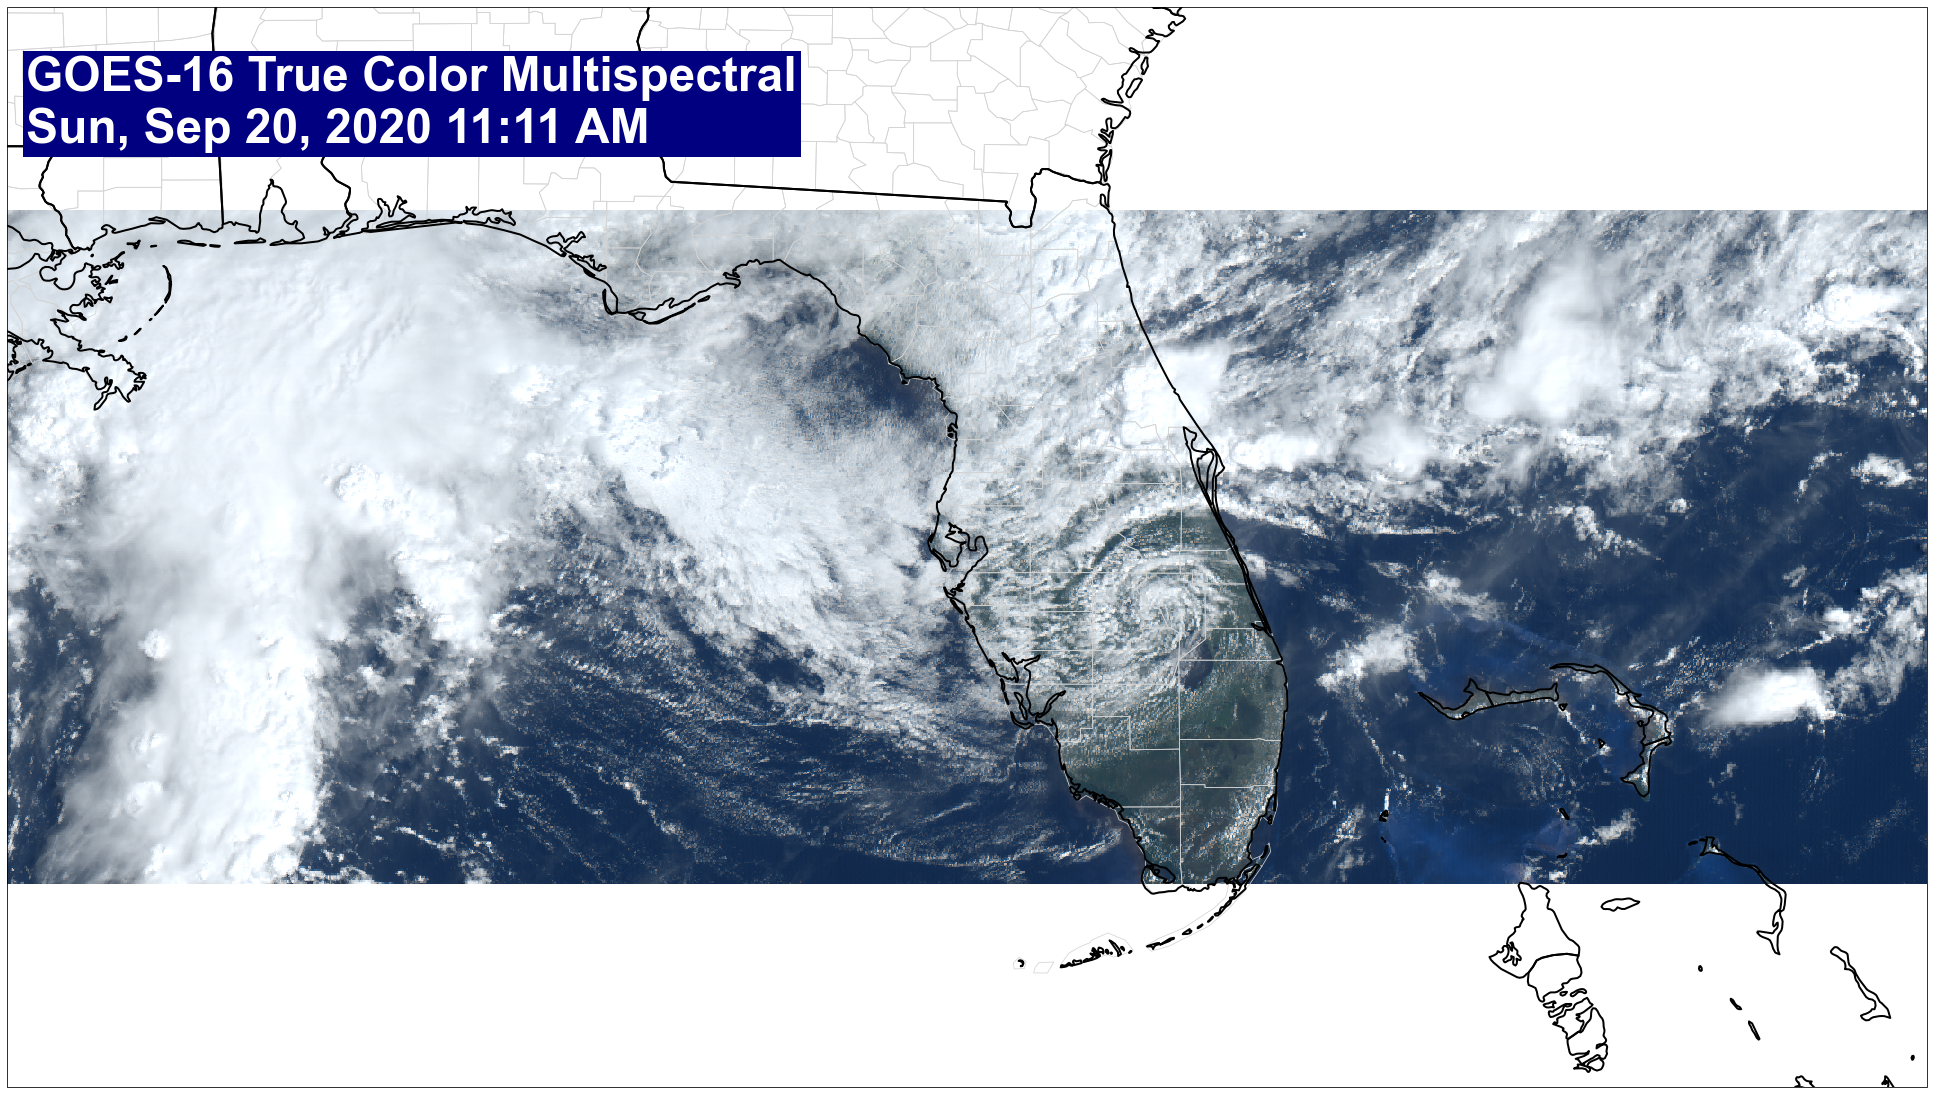

In [15]:
# Build the plot
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

#ax.set_extent([-110.5, -69.5, 20, 41])
#ax.set_extent([-78, -23, 5, 33.5])
ax.set_extent([-90.1, -75, 25.2, 30.5]) # Florida
#ax.set_extent([-89, -75, 23, 37])


ax.imshow(RGB_contrast, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=proj, interpolation='none')

ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=2.0)
ax.set_adjustable('datalim')

# Make the axis title
ax.set_title(f'GOES-16 True Color Multispectral\n{VALID_TIME}', loc='left', 
             ha='left', va='top', fontsize=48, fontname='Arial',
             color='white', fontweight='bold', y=0.95, x=0.01,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

# Save and show figure
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'satellite'
plt.savefig(f'{graphics_dir}/vis_truecolor.png', dpi=72)
plt.show()